In [1]:
!pip install keras-multi-head

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-multi-head: filename=keras_multi_head-0.29.0-py3-none-any.whl size=14974 sha256=21ec99b05bccc432b5ef1a42e5d2a4605d3f02e617128f515ea651117065f8ab
  Stored in directory: /root/.cache/pip/wheels/19/fe/36/14fd933930357c34331e65e11aa5380e35188df2223b113358
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=9cf8c23b9a74cd2ab1740dae3e3ea7110e93a4c92c570ec72f234adc2c0cfa55
  Stored in directory: /root/.cache/pip/wheels/46/f9/96/709295c836133071c12a300729fed4027757f889c01695feea
Successfully built keras-multi-head keras-self-attention


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/IMU/Annotated_Data

/content/drive/MyDrive/IMU/Annotated_Data


In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import os

In [6]:
el_folder = 'EL'
pd_folder = 'PD'
frame_size = 100
all_frames = []
outputs = []

In [7]:
data_features = []
labels=[]

# function to read and extract relevant columns
def process_file(file_path, label):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Selecting only relevant columns for right foot acceleration
    relevant_columns = [col for col in df.columns if 'right acceleration' in col]

    df = df[relevant_columns]

    # Drop rows with NaN values in the relevant columns
    df = df.dropna()

     # Check if DataFrame is not empty
    if not df.empty:
        # Convert data to a NumPy array and append it to the main data list
        data_features.append(df.to_numpy())
        # Append the corresponding label for each file
        labels.append(label)
    else:
        print(f"Warning: {file_path} has no valid data after dropping NaN values.")

# Loop through EL files and assign label 0
for file_name in os.listdir(el_folder):
    if file_name.endswith('.xlsx'):
        process_file(os.path.join(el_folder, file_name), label=0)

# Loop through PD files and assign label 1
for file_name in os.listdir(pd_folder):
    if file_name.endswith('.xlsx'):
        process_file(os.path.join(pd_folder, file_name), label=1)

data_features = np.array(data_features, dtype=object)
labels = np.array(labels)

In [8]:
num_to_print = 2 # Change this to print more or fewer arrays

print("First few arrays in the data list:")
for i in range(min(num_to_print, len(data_features))):
    print(f"Array {i + 1}:")
    print(f"Label: {labels[i]}")
    print(f"Data Shape: {data_features[i].shape}")
    print(data_features[i])  # Print the actual array
    print("-" * 50)

First few arrays in the data list:
Array 1:
Label: 0
Data Shape: (2272, 3)
[[-0.249023  0.089844  0.975586]
 [-0.251465  0.093262  0.968262]
 [-0.242188  0.090332  0.975098]
 ...
 [-0.257812  0.098145  0.972656]
 [-0.256836  0.091797  0.972168]
 [-0.256836  0.091797  0.972168]]
--------------------------------------------------
Array 2:
Label: 0
Data Shape: (2337, 3)
[[-0.473145  0.078613  0.885742]
 [-0.474121  0.07666   0.881836]
 [-0.470703  0.073242  0.884277]
 ...
 [-0.738281  0.100098  0.67334 ]
 [-0.662598  0.185547  0.720703]
 [-0.605957  0.189453  0.714844]]
--------------------------------------------------


# **DATA PREPROCESSING**

In [9]:
import torch

In [10]:
# Divide data into frames of 100 rows

for i, participant_data in enumerate(data_features):
    num_frames = len(participant_data) // frame_size
    for j in range(num_frames):
        frame = participant_data[j * frame_size: (j + 1) * frame_size]
        all_frames.append(frame)
        outputs.append(labels[i])

print("Shape of the first frame:", all_frames[0].shape)  # Should be (100, 3)

Shape of the first frame: (100, 3)


In [11]:
# Flatten frames for DataFrame

a_frame = {'label': []}
count_1 = 0

for frame in all_frames:
    for i, f in enumerate(frame.ravel()):  # Flatten the frame
        if i not in a_frame:
            a_frame[i] = []
        a_frame[i].append(f)
    # Use torch.tensor for labels
    a_frame['label'].append(torch.tensor(outputs[count_1], dtype=torch.long))
    count_1 += 1


# Convert to DataFrame
df = pd.DataFrame(a_frame)

#Move 'label' column to the last position
cols = [col for col in df.columns if col != 'label']  # Get feature columns
cols.append('label')  # Add 'label' at the end
df = df[cols]  # Reorder DataFrame


# Display the first few rows of the DataFrame
print(df.head())

print("Number of features:", len(df.columns))
print("Original DataFrame shape:", df.shape)

print("First 5 feature columns:", df.columns[:5])
print("Last column name (should be 'label'):", df.columns[-1])

          0         1         2         3         4         5         6  \
0 -0.249023  0.089844  0.975586 -0.251465  0.093262  0.968262 -0.242188   
1 -0.237793  0.099609  0.976074 -0.242188  0.098145  0.972656 -0.239258   
2 -0.177246  0.114258  1.020996 -0.184570  0.106934  1.036133 -0.179199   
3 -0.378418 -1.136719  1.832520 -0.359375  0.725098  1.540039 -0.357910   
4 -3.137207 -1.635254 -0.961426 -3.137207 -1.635254 -0.961426  1.355957   

          7         8         9  ...       291       292       293       294  \
0  0.090332  0.975098 -0.244141  ... -0.242188  0.102051  0.973145 -0.240723   
1  0.101074  0.974609 -0.240234  ... -0.162109  0.082031  0.991211 -0.186523   
2  0.108887  1.030762 -0.163574  ... -0.632324  0.020508 -0.137207 -0.957031   
3  0.317383  1.375488 -0.416504  ... -3.561035 -1.218750 -0.275879 -3.508789   
4 -0.495605  2.506836  0.417480  ... -2.028809  0.021484  2.499023 -2.362305   

        295       296       297       298       299      label  
0  

In [ ]:
from tabulate import tabulate
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))

+---+-------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------+-----------+----------+----------+-----------+-----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+---

In [11]:
print(f"Shape of DataFrame: {df.shape}")

print("\nFirst few rows of the DataFrame:")
print(df.head())

print("\nColumn names in the DataFrame:")
print(df.columns)

print("\nUnique labels in the DataFrame:")
print(df['label'].unique())

print("\nRandom samples from the DataFrame:")
print(df.sample(10))

Shape of DataFrame: (3138, 301)

First few rows of the DataFrame:
          0         1         2         3         4         5         6  \
0 -0.249023  0.089844  0.975586 -0.251465  0.093262  0.968262 -0.242188   
1 -0.237793  0.099609  0.976074 -0.242188  0.098145  0.972656 -0.239258   
2 -0.177246  0.114258  1.020996 -0.184570  0.106934  1.036133 -0.179199   
3 -0.378418 -1.136719  1.832520 -0.359375  0.725098  1.540039 -0.357910   
4 -3.137207 -1.635254 -0.961426 -3.137207 -1.635254 -0.961426  1.355957   

          7         8         9  ...       291       292       293       294  \
0  0.090332  0.975098 -0.244141  ... -0.242188  0.102051  0.973145 -0.240723   
1  0.101074  0.974609 -0.240234  ... -0.162109  0.082031  0.991211 -0.186523   
2  0.108887  1.030762 -0.163574  ... -0.632324  0.020508 -0.137207 -0.957031   
3  0.317383  1.375488 -0.416504  ... -3.561035 -1.218750 -0.275879 -3.508789   
4 -0.495605  2.506836  0.417480  ... -2.028809  0.021484  2.499023 -2.362305   

  

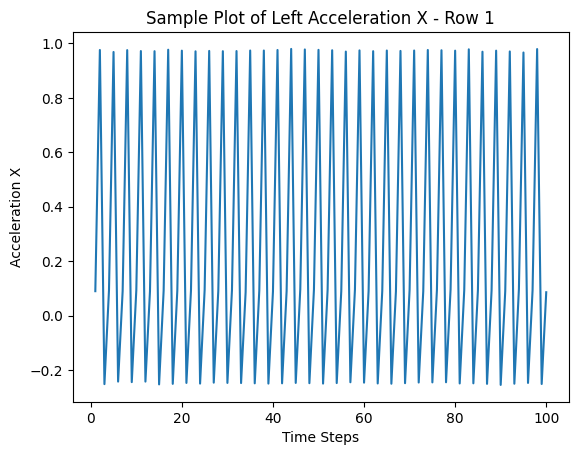

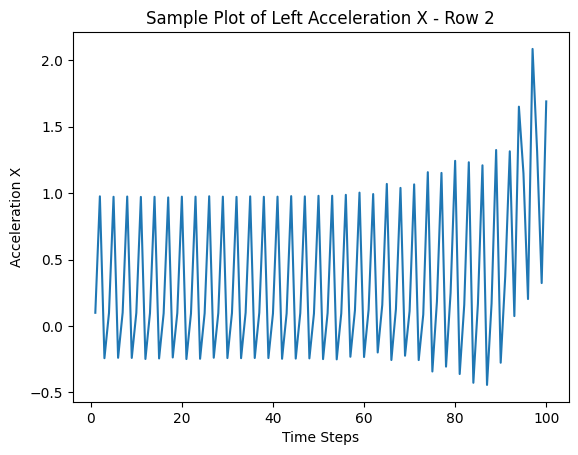

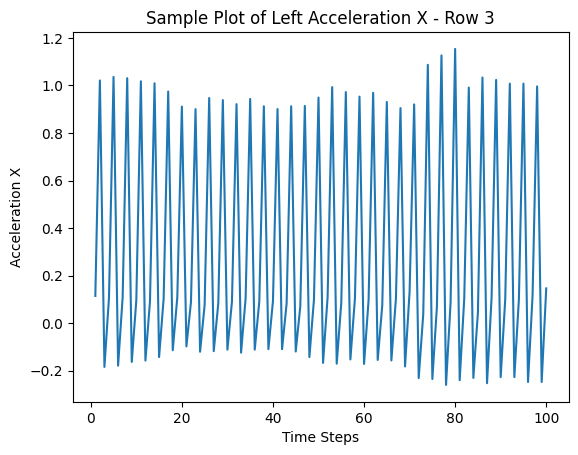

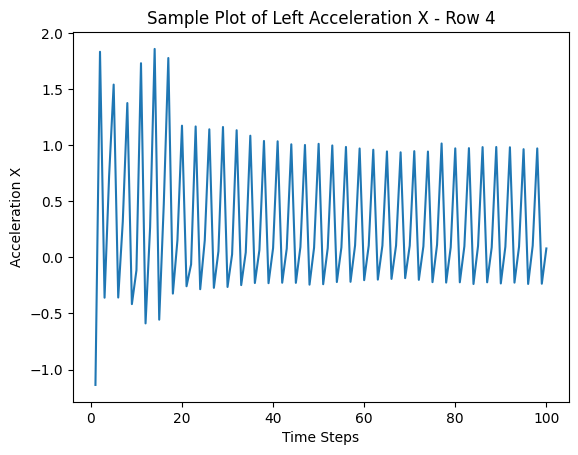

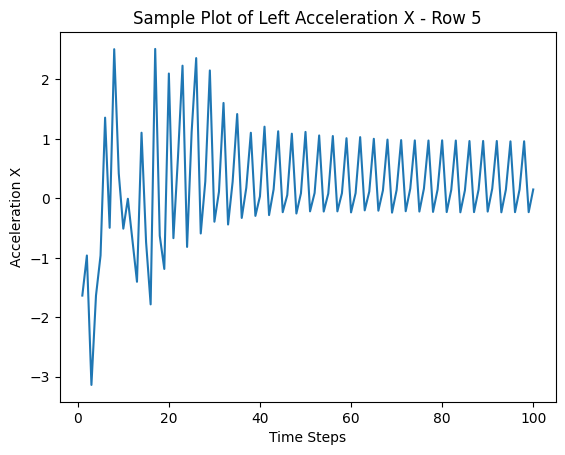

In [14]:
# Example: Plot a few rows of left acceleration X
for i in range(5):  # Plot the first 5 rows
    plt.plot(df.iloc[i, 1:frame_size+1])  # Adjust the slice to the relevant columns
    plt.title(f"Sample Plot of Left Acceleration X - Row {i+1}")
    plt.xlabel("Time Steps")
    plt.ylabel("Acceleration X")
    plt.show()

In [12]:
el_files = [f for f in os.listdir(el_folder) if f.endswith('.xlsx')]
pd_files = [f for f in os.listdir(pd_folder) if f.endswith('.xlsx')]

# Print the counts for each folder
print(f"Total files in EL folder: {len(el_files)}")
print(f"Total files in PD folder: {len(pd_files)}")

# Calculate and print the total number of files used
total_files = len(el_files) + len(pd_files)
print(f"Total files used in the code: {total_files}")

Total files in EL folder: 71
Total files in PD folder: 32
Total files used in the code: 103


In [13]:
print(f"Frame size : {frame_size}")
print(f"Data points: {len(outputs)}")
print(f"Positive samples: {outputs.count(1)}")

Frame size : 100
Data points: 3138
Positive samples: 1303


# **Model**

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [13]:
class PostionalEncoding(nn.Module):
    def __init__(
        self,
        dropout: float=0.1,
        max_seq_len: int=5000,
        d_model: int=512,
        batch_first: bool=False    ):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0
        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_seq_len, 1, d_model)
        #pe = torch.zeros(max_seq_len, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)

        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size = x.shape[0]  # Get the batch size     # 7
        seq_len = x.shape[1]  # Get the sequence length   # 200

        print("Input shape (x):", x.shape)  # Debugging: Print input shape    # torch.Size([7, 200])

        # Expand the positional encoding to match the batch size
        # and sequence length of the input tensor
        pe_expanded = self.pe[:seq_len, :].repeat(1, batch_size, 1)

        # Permute the positional encoding to match the input tensor
        pe_expanded = pe_expanded.permute(1, 0, 2)

        x = x + pe_expanded

        x = self.dropout(x)

        #x = x.permute(1, 0, 2) # No need for permutation here
        return x

class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob,details):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head, details=details)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.details = details
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x )

        #if self.details: print('in encoder layer : '+ str(x.size()))
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        #if self.details: print('in encoder after norm layer : '+ str(x.size()))
        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)

        #if self.details: print('in encoder after ffn : '+ str(x.size()))
        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

class Encoder(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, n_layers, drop_prob,details, device):
        super().__init__()


        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head
                                                  ,details=details,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x ):
        for layer in self.layers:
            x = layer(x )
        return x

class ClassificationHead(nn.Module):
    def __init__(self,d_model, seq_len , details, n_classes: int = 5):
      super().__init__()
      self.norm = nn.LayerNorm(d_model)
      self.details = details
      #self.flatten = nn.Flatten()
      self.seq = nn.Sequential( nn.Flatten() , nn.Linear(d_model * seq_len , 512) ,nn.ReLU(),nn.Linear(512, 256)
                               ,nn.ReLU(),nn.Linear(256, 128),nn.ReLU(),nn.Linear(128, n_classes))

    def forward(self,x):

      #if self.details:  print('in classification head : '+ str(x.size()))
      x= self.norm(x)
      #x= self.flatten(x)
      x= self.seq(x)
      #if self.details: print('in classification head after seq: '+ str(x.size()))
      return x

In [14]:
class Transformer(nn.Module):

    def __init__(self,device, d_model=100, n_head=4, max_len=5000, seq_len=200,
                 ffn_hidden=128, n_layers=2, drop_prob=0.1, details =False):
        super().__init__()
        self.device = device
        self.details = details
        self.encoder_input_layer = nn.Linear(
            in_features=3,
            out_features=d_model
            )

        self.pos_emb = PostionalEncoding( max_seq_len=max_len,batch_first=False, d_model=d_model, dropout=0.1)
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               ffn_hidden=ffn_hidden,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               details=details,
                               device=device)
        self.classHead = ClassificationHead(seq_len=seq_len,d_model=d_model,details=details,n_classes=5)

    def forward(self, src ):
        #if self.details: print('before input layer: '+ str(src.size()) )
        src= self.encoder_input_layer(src)
        #if self.details: print('after input layer: '+ str(src.size()) )
        src= self.pos_emb(src)
        #if self.details: print('after pos_emb: '+ str(src.size()) )
        enc_src = self.encoder(src)
        cls_res = self.classHead(enc_src)
        #if self.details: print('after cls_res: '+ str(cls_res.size()) )
        return cls_res

class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self, details):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)
        self.details = details
    def forward(self, q, k, v ,e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose

        #if self.details: print('in Scale Dot Product, k_t size: '+ str(k_t.size()))
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product


        #if self.details: print('in Scale Dot Product, score size: '+ str(score.size()))
        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        #if self.details: print('in Scale Dot Product, score size after softmax : '+ str(score.size()))

        #if self.details: print('in Scale Dot Product, v size: '+ str(v.size()))
        # 4. multiply with Value
        v = score @ v

        #if self.details: print('in Scale Dot Product, v size after matmul: '+ str(v.size()))
        return v, score

class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension.

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        print("Input to model shape:", x.shape)
        return x

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_head, details):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention( details=details)
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
        self.details = details

    def forward(self, q, k, v ):
        # 1. dot product with weight matrices

        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        #if self.details: print('in Multi Head Attention Q,K,V: '+ str(q.size()))
        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        #if self.details: print('in splitted Multi Head Attention Q,K,V: '+ str(q.size()))
        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v )

        #if self.details: print('in Multi Head Attention, score value size: '+ str(out.size()))
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        #if self.details: print('in Multi Head Attention, score value size after concat : '+ str(out.size()))
        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

In [15]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

class IMUdataset(Dataset):
    def __init__(self,x,y)  :
        super().__init__()
        #file_out = pd.read_csv(fileName)
        #x = file_out.iloc[:,:-1].values
        #y = file_out.iloc[:,-1:].values
        self.X = torch.tensor(x)
        self.Y = torch.tensor(y)
        print('X shape: '+ str(self.X.size()))  # torch.Size([2510, 300])   # torch.Size([628, 300])
        print('Y shape: '+ str(self.Y.size()))    # torch.Size([2510, 1])   # torch.Size([628, 1])

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        #return self.X[index].unsqueeze(1), self.Y[index]
        return self.X[index], self.Y[index] # Remove unsqueeze(1)   # Return features and labels


class MyTestDataLoader():
    def __init__(self, batch_size) -> None:
        self.batch_size = batch_size
        file_out_test = pd.read_csv('mitbih_test.csv')

        x_test = file_out_test.iloc[:,:-1].values
        y_test = file_out_test.iloc[:,-1:].astype(dtype=int).values

        # Reshape to (num_samples, 100, 3)
        x_test = x_test.reshape(x_test.shape[0], 100, 3)

        print("Reshaped x_test shape:", x_test.shape)  # Debugging

        test_set= IMUdataset(x= x_test, y= y_test)
        self.dataLoader= DataLoader(test_set, batch_size=self.batch_size, shuffle=True,  )

    def getDataLoader(self):
        return self.dataLoader

class myDataLoader():
    def __init__(self, batch_size) -> None:
        self.batch_size = batch_size
        #file_out_train = pd.read_csv('mitbih_train.csv')

        x_train = df.iloc[:,:-1].values
        y_train = df.iloc[:,-1:].astype(dtype=int).values
        #x_train = all_frames
        #y_train = outputs
        x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.20 )

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        # Reshape to (num_samples, 100, 3)
        x_train = x_train.reshape(x_train.shape[0], 100, 3)
        x_val = x_val.reshape(x_val.shape[0], 100, 3)


        # Print shapes for debugging
        print("x_train shape:", x_train.shape)  # Should be (num_samples, 300)  # x_train shape: (2510, 300)
        print("y_train shape:", y_train.shape)  # Should be (num_samples,)      # y_train shape: (2510, 1)


        #print("x_train shape on batch size =  " + str(x_train.shape ))
        #print('x_val shape on batch size =  ' + str(x_val.shape))
        #print('y_train shape on batch size =  '+ str(y_train.shape ))
        #print('y_val shape on batch size =  ' + str( y_val.shape) )

        train_set= IMUdataset(x= x_train, y= y_train)

        val_set= IMUdataset(x= x_val, y= y_val)

        dataloaders = {
            'train': DataLoader(train_set, batch_size=batch_size, shuffle=True,  ),
            'val': DataLoader(val_set, batch_size=batch_size, shuffle=True,  )
        }
        self.dataloaders = dataloaders


    def getDataLoader(self):
        return self.dataloaders

In [16]:
def cross_entropy_loss(pred, target):

    criterion = nn.CrossEntropyLoss()
    #print('pred : '+ str(pred ) + ' target size: '+ str(target.size()) + 'target: '+ str(target )+   ' target2: '+ str(target))
    #print(  str(target.squeeze( -1)) )
    target=target.long()
    #pred=pred.long()
    lossClass= criterion(pred, target )

    return lossClass


def calc_loss_and_score(pred, target, metrics):
    softmax = nn.Softmax(dim=1)

    pred =  pred.squeeze( -1)
    target= target.squeeze( -1)

    ce_loss = cross_entropy_loss(pred, target)
    #metrics['loss'] += ce_loss.data.cpu().numpy() * target.size(0)
    #metrics['loss'] += ce_loss.item()* target.size(0)
    metrics['loss'] .append( ce_loss.item() )
    pred = softmax(pred )

    #lossarr.append(ce_loss.item())
    #print('metrics : '+ str(ce_loss.item())  )
    #print('predicted max before = '+ str(pred))
    #pred = torch.sigmoid(pred)
    _,pred_labels = torch.max(pred, dim=1)


    #print('predicted max = '+ str(pred ))
    #print('target = '+ str(target ))
    metrics['correct']  += torch.sum(pred_labels ==target ).item()
    #print('correct sum =  '+ str(torch.sum(pred==target ).item()))
    metrics['total']  += target.size(0)
    #print('target size  =  '+ str(target.size(0)) )

    return ce_loss


def print_metrics(main_metrics_train,main_metrics_val,metrics, phase):

    correct= metrics['correct']
    total= metrics['total']
    accuracy = 100*correct / total
    loss= metrics['loss']

    if phase == 'train':
        main_metrics_train['loss'].append(np.mean(loss))
        main_metrics_train['accuracy'].append(accuracy)

    else:
        main_metrics_val['loss'].append(np.mean(loss))
        main_metrics_val['accuracy'].append(accuracy)


    result = "phase: "+str(phase) \
    +  ' \nloss : {:4f}'.format(np.mean(loss))   +    ' accuracy : {:4f}'.format(accuracy)        +"\n"
    return result



def train_model(dataloaders,model,optimizer, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_dict = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    val_dict = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['val', 'train']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                #print(f"Input shape: {inputs.shape}")  # Should be (batch_size, sequence_length, num_features)    # torch.Size([7, 300])
                #print(f"Labels shape: {labels.shape}")  # Should be (batch_size,)   torch.Size([7, 1])
                #break

                inputs = inputs.to(device=device, dtype=torch.float)
                labels = labels.to(device=device, dtype=torch.int)
                # zero the parameter gradients
                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    #print('outputs size: '+ str(outputs.size()) )
                    loss = calc_loss_and_score(outputs, labels, metrics)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                  # Store predictions and true labels for metric calculations
                _, preds = torch.max(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # statistics
                #print('epoch samples: '+ str(epoch_samples))
            print(print_metrics(main_metrics_train=train_dict, main_metrics_val=val_dict,metrics=metrics,phase=phase ))
            epoch_loss = np.mean(metrics['loss'])

            accuracy = 100 * metrics['correct'] / metrics['total']

            if phase == 'train':
                train_dict['loss'].append(epoch_loss)
                train_dict['accuracy'].append(accuracy)
            else:
                val_dict['loss'].append(epoch_loss)
                val_dict['accuracy'].append(accuracy)

            if phase == 'val' and epoch_loss < best_loss:
                    print("saving best model")
                    best_loss = epoch_loss

    print('Best val loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)

    print("Unique labels in ground truth:", np.unique(all_labels))
    print("Unique labels in predictions:", np.unique(all_preds))

    unique, counts = np.unique(all_labels, return_counts=True)
    print(dict(zip(unique, counts)))

    # Calculate and print the overall metrics
    avg_accuracy = accuracy_score(all_labels, all_preds) * 100
    avg_precision = precision_score(all_labels, all_preds, average='weighted') * 100
    avg_recall = recall_score(all_labels, all_preds, average='weighted') * 100
    avg_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n\nMetrics Summary:\n")
    print(f"  Average Accuracy:   {avg_accuracy:.2f}%")
    print(f"  Average Precision:  {avg_precision:.2f}%")
    print(f"  Average Recall:     {avg_recall:.2f}%")
    print(f"  Average F1 Score:   {avg_f1:.2f}%\n")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot the metrics
    plot_metrics(train_dict, val_dict, num_epochs)


#device = torch.device("mps")
device = torch.device('cpu')
sequence_len=100 # sequence length of time series/ Sampling Rate: 100 Hz
max_len=100 # max time series sequence length
n_head = 4 # number of attention head
n_layer = 2 # number of encoder layer
drop_prob = 0.1
d_model = 200 # number of dimension ( for positional embedding)
ffn_hidden = 512 # size of hidden layer before classification
feature = 1 # for univariate time series (1d), it must be adjusted for 1.
model =  Transformer(  d_model=d_model, details=True, n_head=n_head, max_len=max_len, seq_len=sequence_len, ffn_hidden=ffn_hidden, n_layers=n_layer, drop_prob=drop_prob,device='cpu')

batch_size = 7
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
dataloaders= myDataLoader(batch_size=batch_size).getDataLoader()

x_train shape: (2510, 100, 3)
y_train shape: (2510, 1)
X shape: torch.Size([2510, 100, 3])
Y shape: torch.Size([2510, 1])
X shape: torch.Size([628, 100, 3])
Y shape: torch.Size([628, 1])


In [22]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d820c507590>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7d82000bb9d0>}

Streaming output truncated to the last 5000 lines.
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input to model shape: torch.Size([7, 100, 200])
Input shape (x): to

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Metrics Summary:

  Average Accuracy:   57.13%
  Average Precision:  55.27%
  Average Recall:     57.13%
  Average F1 Score:   50.10%



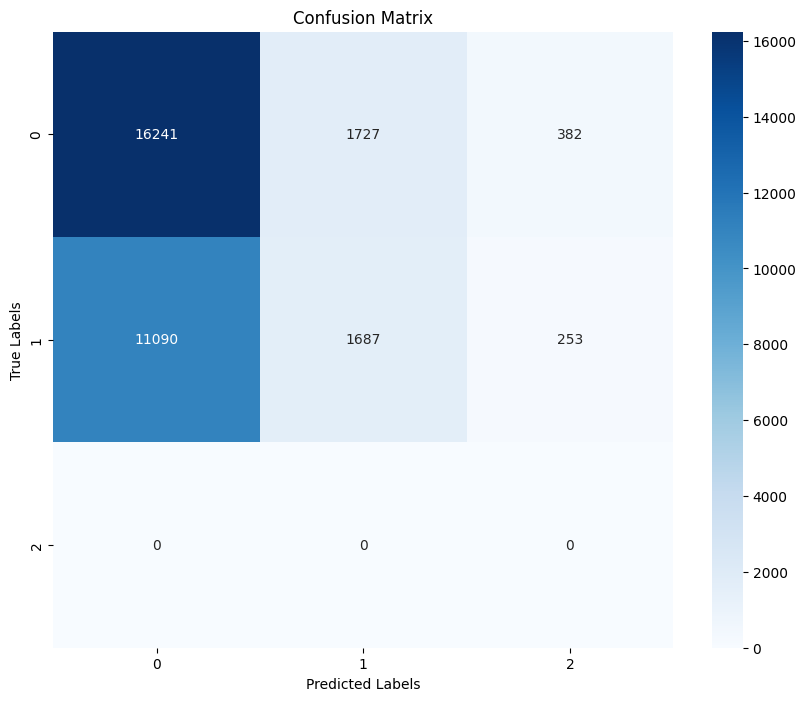

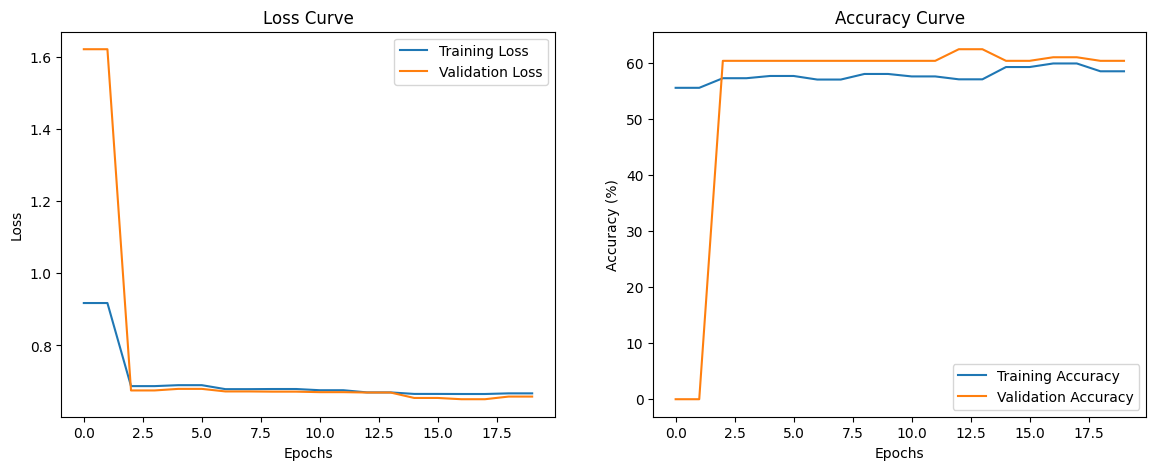

In [23]:
model_normal_ce = train_model(dataloaders=dataloaders, model=model, optimizer=optimizer, num_epochs=10)
torch.save(model.state_dict(), 'myModel')

In [20]:
# Function to plot accuracy and loss curves
def plot_metrics(train_metrics, val_metrics, num_epochs):
    epochs = range(len(train_metrics['loss']))
    #epochs = range(num_epochs)

    # Plot loss curves
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metrics['loss'], label='Training Loss')
    plt.plot(epochs, val_metrics['loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metrics['accuracy'], label='Training Accuracy')
    plt.plot(epochs, val_metrics['accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
